In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import numpy as np

# Load dataset
data = pd.read_csv('C:/Users/LuisEduardo/OneDrive/Data analyst Portfolio/Natural Gas Forecast/daily_csv.csv')

# Display initial data
data.tail()

,TRADE_DATE,Price
9894,09/02/2024,1.445
9895,10/02/2024,1.445
9896,11/02/2024,1.445
9897,12/02/2024,1.470
9898,13/02/2024,1.290


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9899 entries, 0 to 9898
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TRADE_DATE  9899 non-null   object 
 1   Price       9894 non-null   float64
dtypes: float64(1), object(1)
memory usage: 154.8+ KB


In [3]:
data.isnull().sum()

TRADE_DATE    0
Price         5
dtype: int64

In [4]:
# Reemplazar valores infinitos por NaN
data['Price'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN
data.dropna(subset=['Price'], inplace=True)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


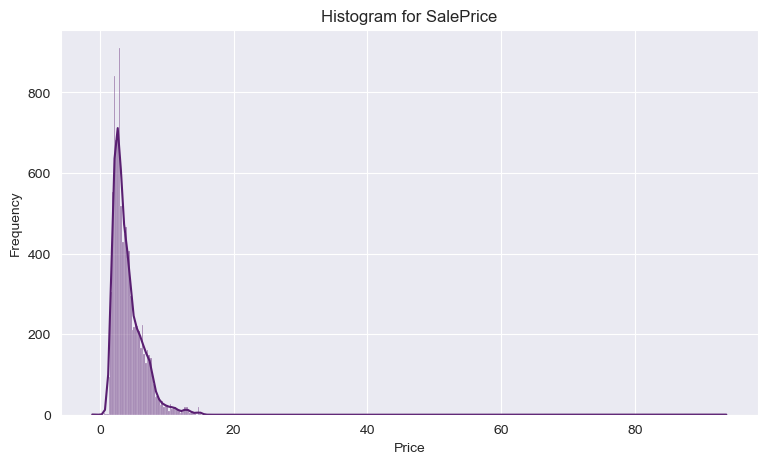

In [5]:
# Configurar el estilo de la cuadrícula
sns.set_style('darkgrid')
sns.set_color_codes(palette='dark')

# Configurar el área del gráfico
f, ax = plt.subplots(figsize=(9, 5))

# Graficar el histograma de la distribución de precios
sns.histplot(data['Price'], color="m", kde=True, ax=ax)
ax.set(title="Histogram for SalePrice", xlabel='Price', ylabel='Frequency')

# Mostrar el gráfico
plt.show()

In [6]:
# Convert 'Dates' column to datetime for better visualization
data.rename(columns={'TRADE_DATE': 'Date'}, inplace=True)

In [7]:
# Convert the 'DATE' column to datetime with the correct format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', dayfirst=True)

# Confirm that the 'DATE' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


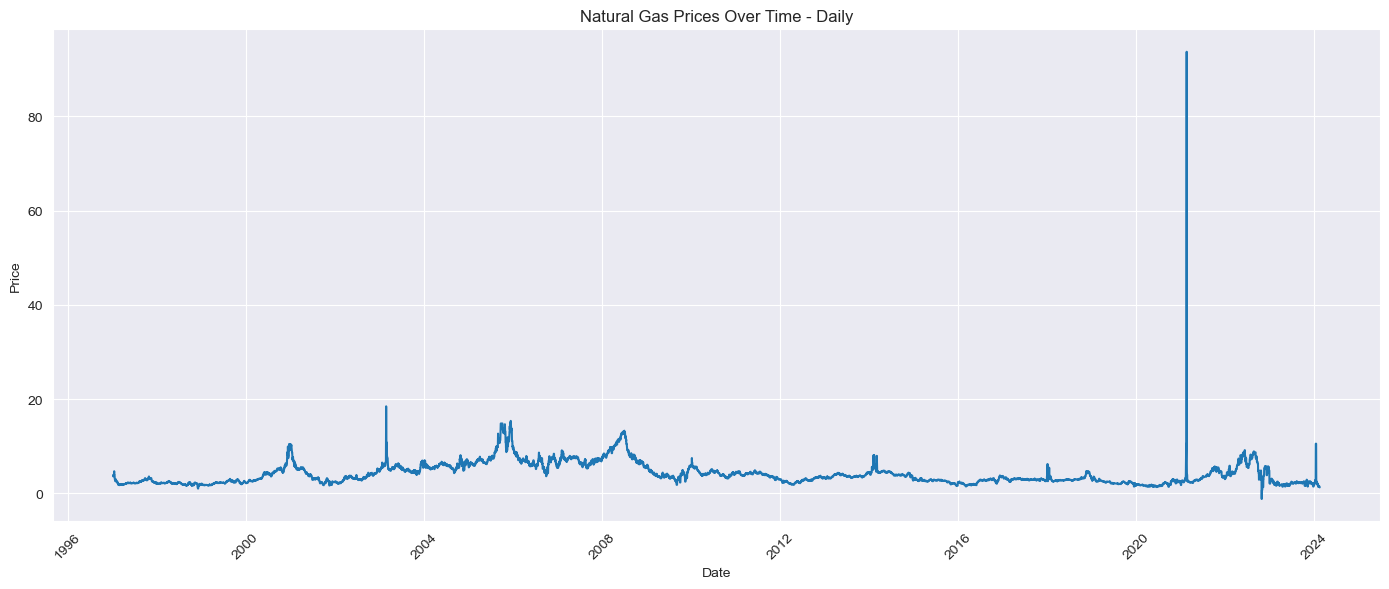

In [8]:
# Configurar el área del gráfico
plt.figure(figsize=(14, 6))

# Graficar la evolución del precio
sns.lineplot(x='Date', y='Price', data=data)

# Configurar los títulos y etiquetas del gráfico
plt.title('Natural Gas Prices Over Time - Daily')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [9]:
def detect_outliers(df, n, features):

    outlier_indices = []

    for col in features:

        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)

        IQR = Q3 - Q1
        print('\n',col)

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        print(outlier_list_col)
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

In [10]:
lof = ['Price']
data_tkm = data[['Date','Price']]
Outliers_to_drop = detect_outliers(data_tkm, 1, lof)


 Price
Index([1434, 1441, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450,
       ...
       8804, 8805, 8806, 8807, 9283, 9284, 9866, 9867, 9868, 9869],
      dtype='int64', length=335)


In [11]:
data_tkm.drop(Outliers_to_drop,inplace=True)

In [12]:
y = data['Price']
size = data.size
print(str(y[Outliers_to_drop].size) + "/" + str(size) + " data points remain.")
print("Turkey Method, " + str(100-((y[Outliers_to_drop].size/size)*100)) +  " % of remained data points from Dataset.")

335/19788 data points remain.
Turkey Method, 98.30705478067516 % of remained data points from Dataset.


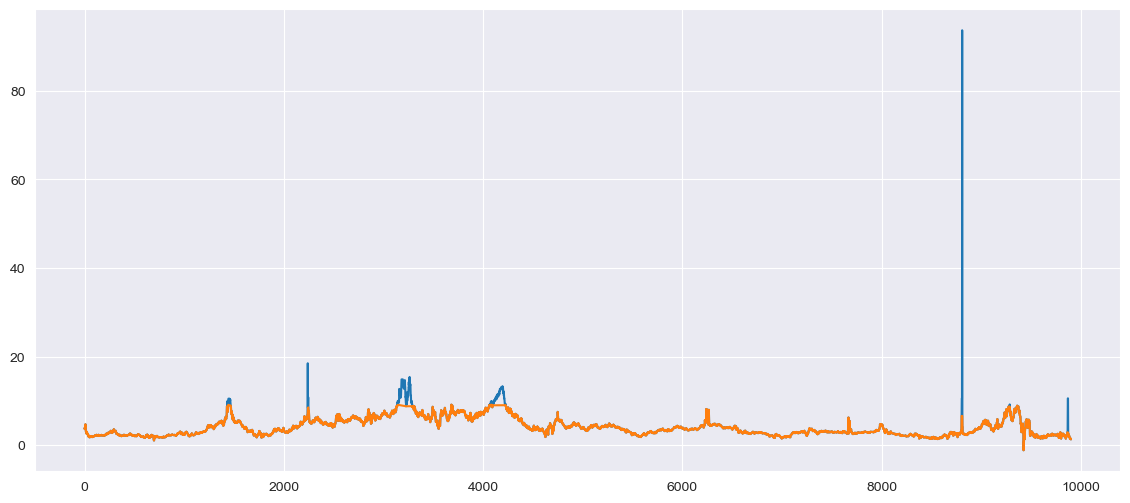

In [13]:
# Configurar el área del gráfico
plt.figure(figsize=(14, 6))
data['Price'].plot().get_figure()
data_tkm['Price'].plot().get_figure()
plt.show()

In [14]:
data = data_tkm

In [15]:
# Crear una nueva columna con el formato 'YYYY-MM'
data['YEAR_MONTH'] = data['Date'].dt.to_period('M')

# Agrupar por la nueva columna 'YEAR_MONTH' y calcular el precio promedio por mes
monthly_avg_price = data.groupby('YEAR_MONTH')['Price'].agg(['mean','std']).reset_index()
monthly_avg_price['cv'] = (monthly_avg_price['std']/monthly_avg_price['mean'])

# Convertir 'YEAR_MONTH' de Period a string para la presentación final
monthly_avg_price['YEAR_MONTH'] = monthly_avg_price['YEAR_MONTH'].astype(str)

# Renombrar las columnas si es necesario
monthly_avg_price.columns = ['Month_Year', 'Average_Price', 'std', 'cv']
monthly_avg_price['Month_Year'] = pd.to_datetime(monthly_avg_price['Month_Year'])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


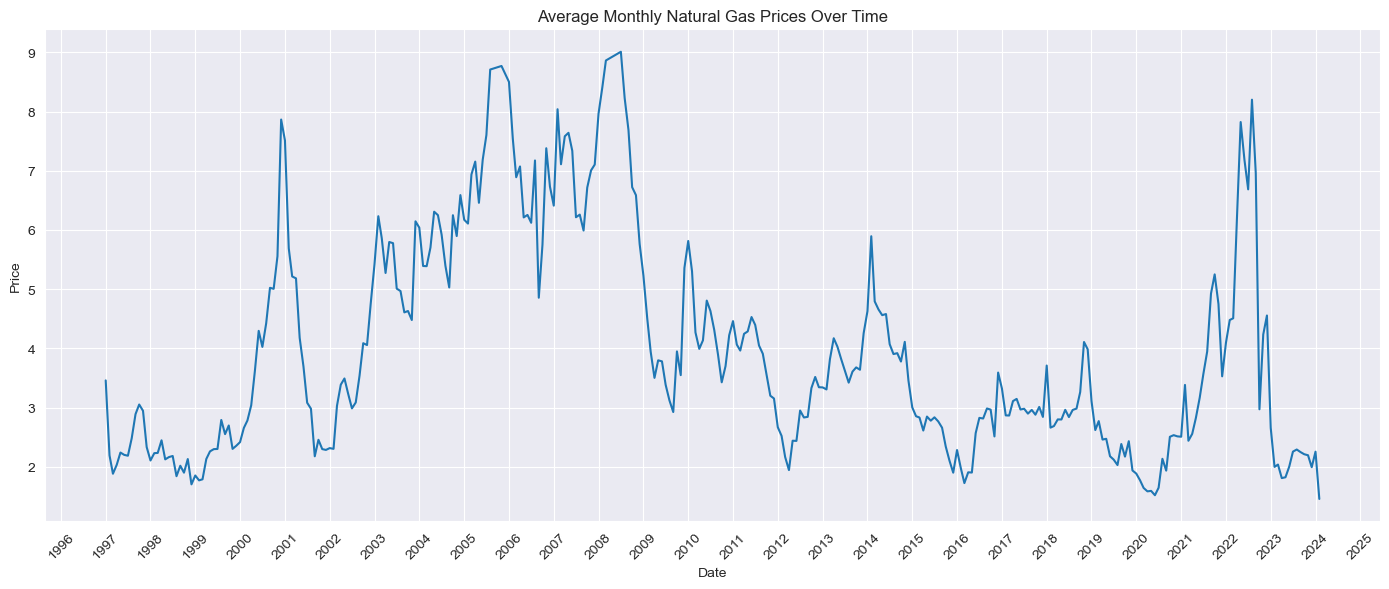

In [16]:
# Configurar el área del gráfico
plt.figure(figsize=(14, 6))

# Graficar la evolución del precio promedio mensual
sns.lineplot(x='Month_Year', y='Average_Price', data=monthly_avg_price)

# Configurar los títulos y etiquetas del gráfico
plt.title('Average Monthly Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Ajustar las etiquetas del eje x para que solo muestren el año
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())  # Muestra cada año

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

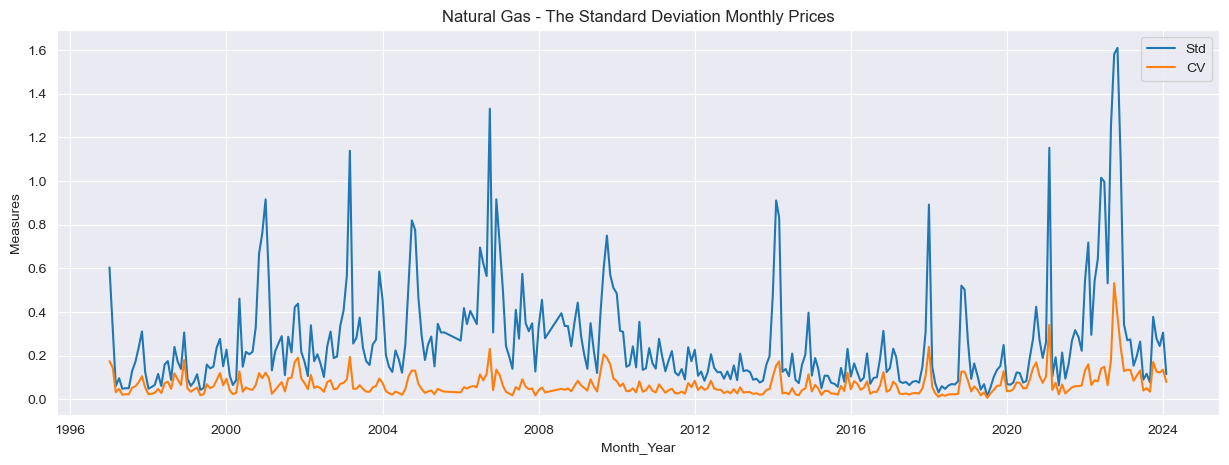

In [17]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Month_Year", y="std",label ='Std',data=monthly_avg_price)
sns.lineplot(x="Month_Year", y="cv",label ='CV',data=monthly_avg_price)

plt.ylabel('Measures')

plt.title("Natural Gas - The Standard Deviation Monthly Prices")

plt.show()

In [18]:
data.columns

Index(['Date', 'Price', 'YEAR_MONTH'], dtype='object')

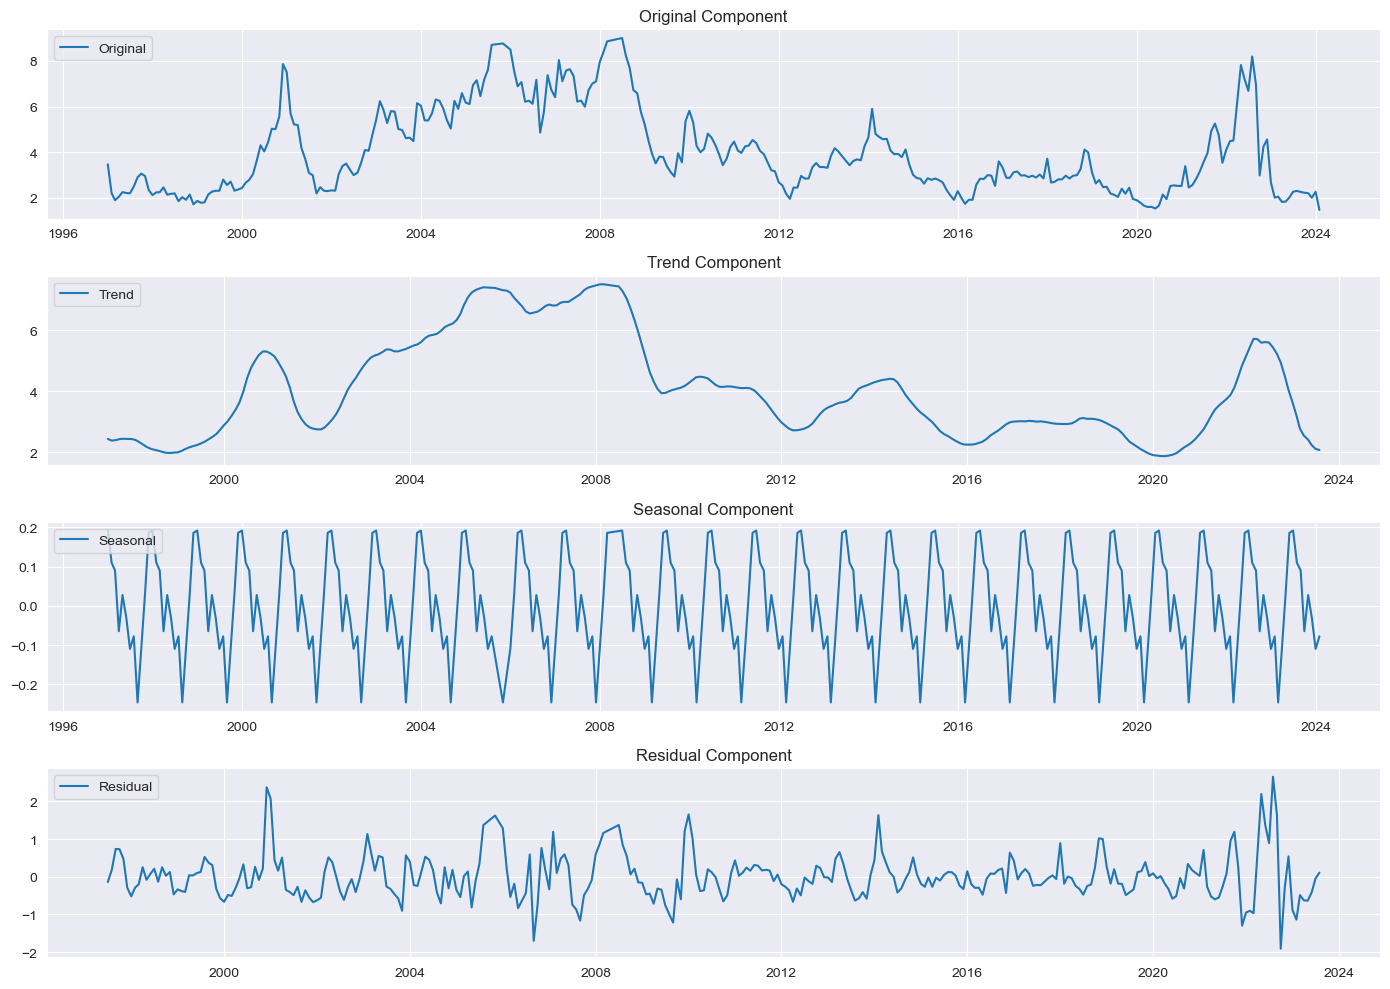

In [19]:
# Decompose the time series to study its components
decomposition = seasonal_decompose(monthly_avg_price['Average_Price'], period=12)  # Assuming yearly seasonality with monthly data

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

labels = ['Original', 'Trend', 'Seasonal', 'Residual']
components = [monthly_avg_price['Average_Price'], decomposition.trend, decomposition.seasonal, decomposition.resid]

for i, ax in enumerate(axes):
    ax.plot(monthly_avg_price['Month_Year'], components[i], label=labels[i])
    ax.legend(loc='upper left')
    ax.set_title(f"{labels[i]} Component")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Test stationarity of the series
def is_stationary(timeseries):
    """Check stationarity using the Augmented Dickey-Fuller test."""
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1] <= 0.05
# Check original and differenced series
is_stationary_original = is_stationary(monthly_avg_price['Average_Price'])

#We then create a differenced series to transform a potentially non-stationary series into a stationary one.
monthly_avg_price.loc[:, 'First Difference'] = monthly_avg_price['Average_Price'].diff()   #calculates the difference between consecutive values in the Price series. This helps in stabilizing the mean of the time series by removing changes in the level of the series, thus potentially making it stationary.

is_stationary_first_diff = is_stationary(monthly_avg_price['First Difference'].dropna())
is_stationary_original, is_stationary_first_diff


(False, True)

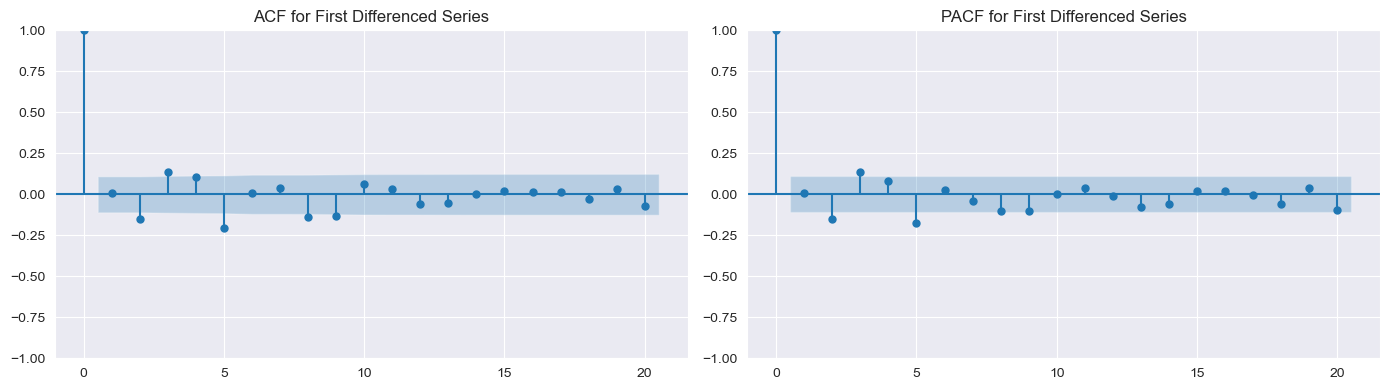

In [21]:
# Plot ACF and PACF for insights into AR and MA terms
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot ACF
plot_acf(monthly_avg_price['First Difference'].dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF for First Differenced Series')

# Plot PACF with method='ywm'
plot_pacf(monthly_avg_price['First Difference'].dropna(), lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF for First Differenced Series')

plt.tight_layout()
plt.show()

In [22]:
# Fit SARIMA model

model = SARIMAX(monthly_avg_price['First Difference'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=-1)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   First Difference   No. Observations:                  320
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -311.168
Date:                            Fri, 07 Jun 2024   AIC                            632.335
Time:                                    22:06:05   BIC                            650.970
Sample:                                         0   HQIC                           639.787
                                            - 320                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0071      0.039      0.182      0.855      -0.069       0.083
ma.L1         -0.9991      0.251     -3.984      0.000      -1.491      -0.508
ar.S.L12      -0.0621      0.074     -0.834      0.404      -0.208       0.084
ma.S.L12      -0.9999     39.939     -0.025      0.980     -79.280      77.280
sigma2         0.3613     14.404      0.025      0.980     -27.871      28.593
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               566.39
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.66
Prob(H) (two-sided):                  0.18   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

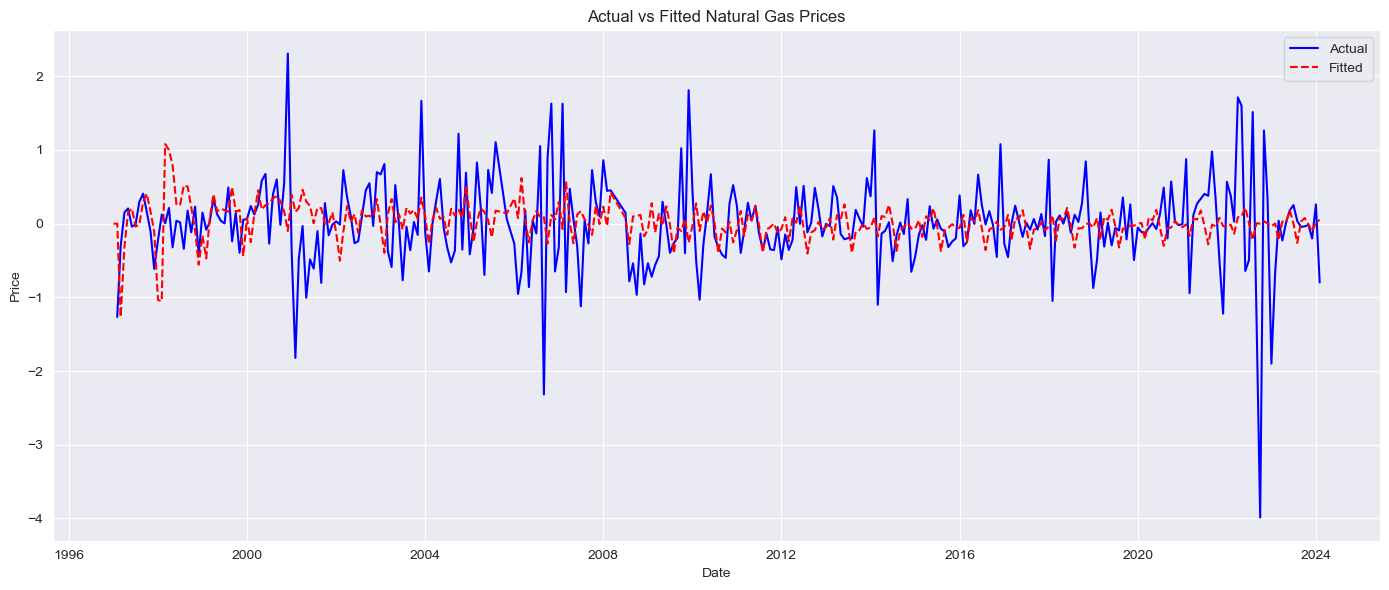

In [23]:
# Compare actual and fitted values
monthly_avg_price['Fitted'] = results.fittedvalues

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['First Difference'], label='Actual', color='blue')
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['Fitted'], label='Fitted', color='red', linestyle='--')
plt.title('Actual vs Fitted Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2024-02-29   -0.220620
2024-03-31    0.131056
2024-04-30    0.116010
2024-05-31    0.122689
2024-06-30   -0.041815
2024-07-31   -0.168480
2024-08-31   -0.061368
2024-09-30   -0.182913
2024-10-31    0.062147
2024-11-30   -0.089214
2024-12-31   -0.113532
2025-01-31    0.017261
2025-02-28   -0.201104
2025-03-31    0.106395
2025-04-30    0.107302
2025-05-31    0.123937
2025-06-30   -0.025960
2025-07-31   -0.158174
2025-08-31   -0.062655
2025-09-30   -0.176173
2025-10-31    0.054836
2025-11-30   -0.098571
2025-12-31   -0.092598
2026-01-31   -0.035772
2026-02-28   -0.204695
2026-03-31    0.105548
2026-04-30    0.105464
2026-05-31    0.121481
2026-06-30   -0.029323
2026-07-31   -0.161192
2026-08-31   -0.064953
2026-09-30   -0.178970
2026-10-31    0.052912
2026-11-30   -0.100369
2026-12-31   -0.096277
2027-01-31   -0.034858
Freq: M, dtype: float64


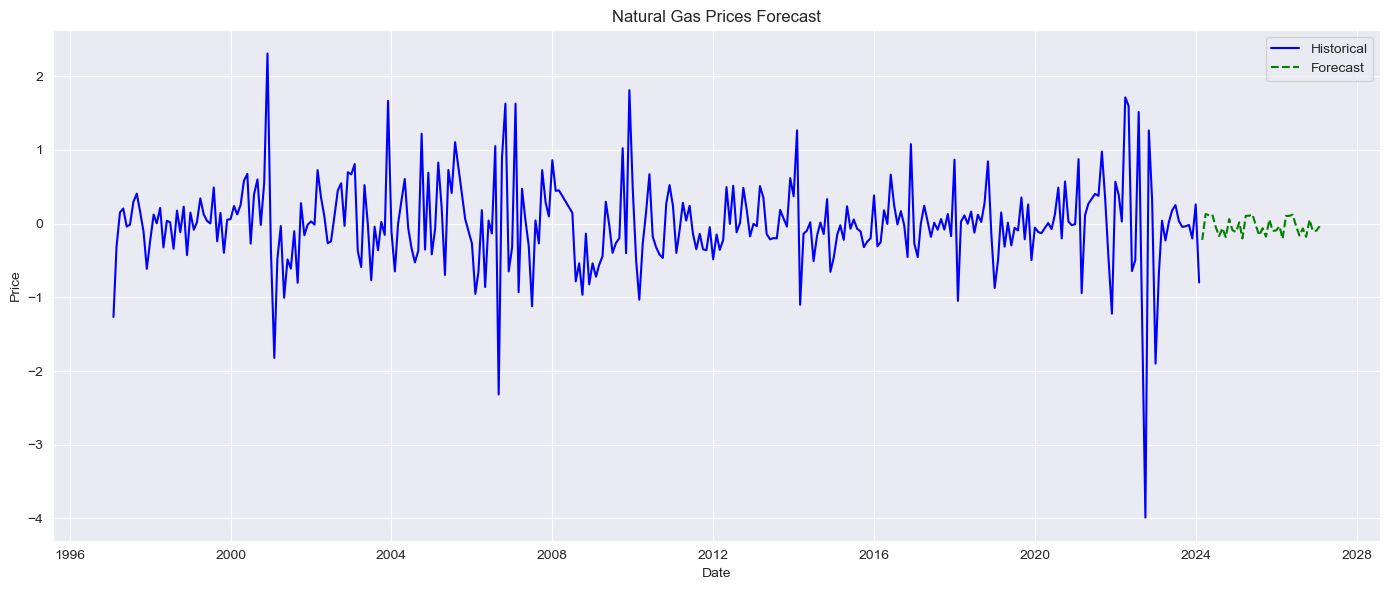

In [24]:
# Forecast for the next three years
forecast = results.get_forecast(steps=36)
forecast_index = pd.date_range(monthly_avg_price['Month_Year'].iloc[-1] + pd.Timedelta(days=1), periods=36, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
print(forecast_series)

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['First Difference'], label='Historical', color='blue')
plt.plot(forecast_index, forecast_series, label='Forecast', color='green', linestyle='--')
#plt.fill_between(forecast_index, forecast.conf_int()['lower Prices'], forecast.conf_int()['upper Prices'], color='green', alpha=0.1)
plt.title('Natural Gas Prices Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prophet Facebook

In [25]:
from prophet import Prophet

In [26]:
prior_scale=0.2
prices_prophet = monthly_avg_price[['Month_Year','First Difference']]

In [27]:
%%time
m = Prophet(changepoint_prior_scale=prior_scale)
prices_prophet.columns = ['ds','y']
m.fit(prices_prophet)

22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:07 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 172 ms
Wall time: 444 ms


In [28]:
# Create a future dataframe
future = m.make_future_dataframe(periods=36, freq='M')
# Predict future values
forecast = m.predict(future)

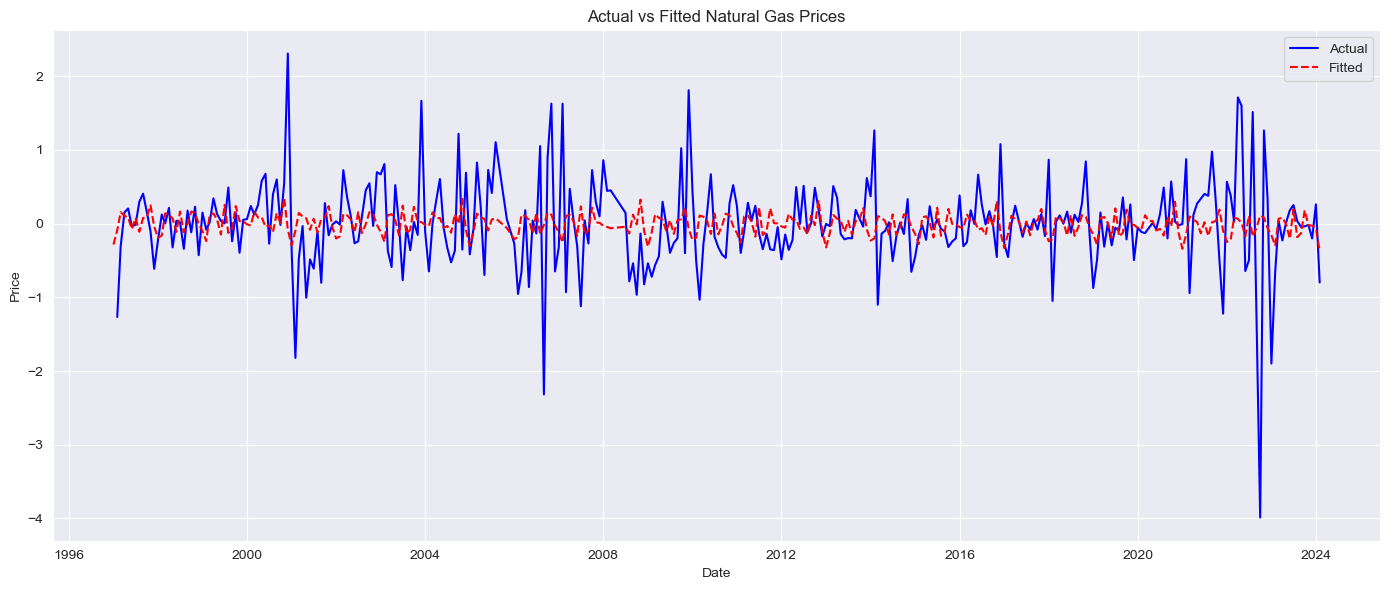

In [29]:
# Compare actual and fitted values
monthly_avg_price['Fitted_P'] = forecast['yhat'] 

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['First Difference'], label='Actual', color='blue')
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['Fitted_P'], label='Fitted', color='red', linestyle='--')
plt.title('Actual vs Fitted Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2024-02-29   -0.371954
2024-03-31    0.051997
2024-04-30    0.096851
2024-05-31   -0.016461
2024-06-30   -0.241584
2024-07-31    0.285654
2024-08-31   -0.194578
2024-09-30   -0.204367
2024-10-31    0.254012
2024-11-30   -0.129494
2024-12-31    0.012290
2025-01-31    0.022936
2025-02-28   -0.449587
2025-03-31    0.038253
2025-04-30    0.113083
2025-05-31   -0.030662
2025-06-30   -0.275428
2025-07-31    0.374643
2025-08-31   -0.207323
2025-09-30   -0.277518
2025-10-31    0.326780
2025-11-30   -0.235450
2025-12-31    0.053484
2026-01-31    0.111604
2026-02-28   -0.528255
2026-03-31    0.025273
2026-04-30    0.129452
2026-05-31   -0.045030
2026-06-30   -0.307812
2026-07-31    0.463424
2026-08-31   -0.221954
2026-09-30   -0.350028
2026-10-31    0.399186
2026-11-30   -0.340893
2026-12-31    0.096921
2027-01-31    0.199115
Name: yhat, dtype: float64


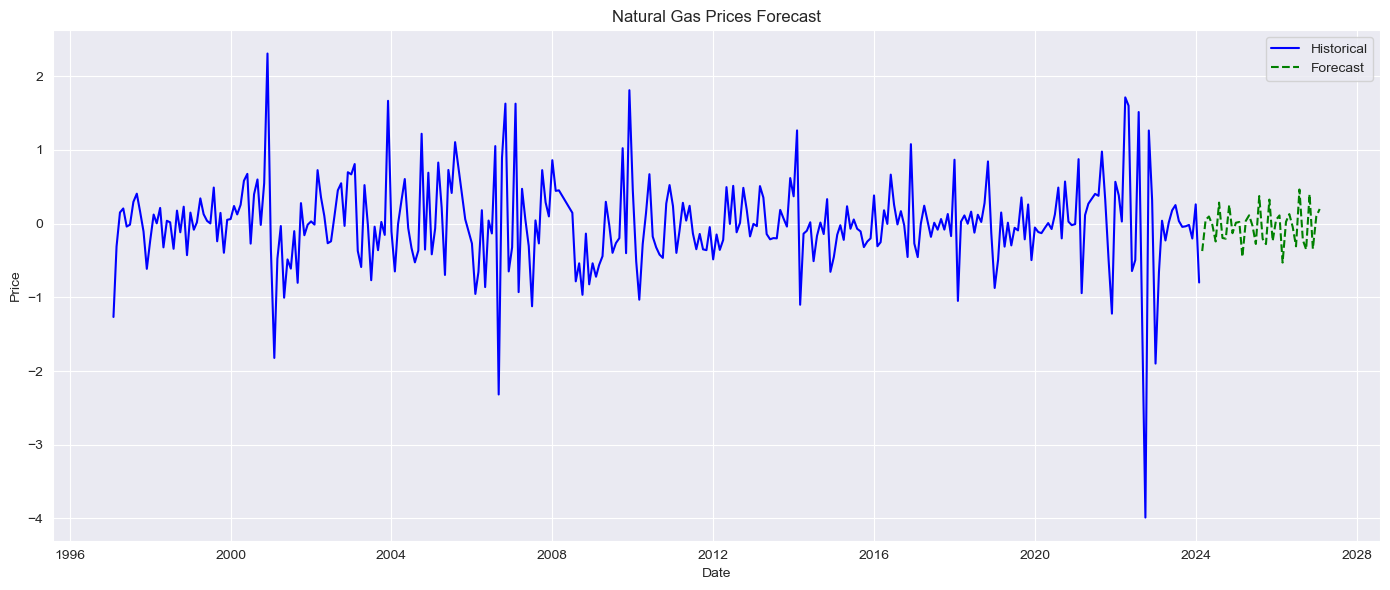

In [30]:
forecast_series = forecast[forecast['ds'] > monthly_avg_price['Month_Year'].iloc[-1]]['yhat']
forecast_series.index = forecast_index.values
print(forecast_series)


plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['Month_Year'], monthly_avg_price['First Difference'], label='Historical', color='blue')
plt.plot(forecast_index, forecast_series, label='Forecast', color='green', linestyle='--')
#plt.fill_between(forecast_index, forecast.conf_int()['lower Prices'], forecast.conf_int()['upper Prices'], color='green', alpha=0.1)
plt.title('Natural Gas Prices Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()